# Million Song Subset Metadata Exploration with Unsupervised Clustering

In the present notebook we perform a first decriptive analysis on a subset of the million song dataset.
This subset is available [here](https://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset).

In [1]:
import numpy as np
from scipy.stats import kurtosis, skew
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb
import sqlite3

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=15)
sb.set_palette('Dark2')
sb.set_style('whitegrid')
path = '../MillionSongSubset/'

# Reading the Metadata SQL table

For this demo the database ``.db`` file is in a separate folder named ``MillionSongSubset/AdditionalFiles/``.
An alternative to the lines below can be found at the following address : https://labrosa.ee.columbia.edu/millionsong/sites/default/files/tutorial1.py.txt

The latter demo was specifically tailored for reading these files.

In [2]:
# creating the connector for the SQL database
con_meta = sqlite3.connect(path+'AdditionalFiles/subset_track_metadata.db')
cur_meta = con_meta.cursor()

In [3]:
# creating and executing an SQL request
res = con_meta.execute("SELECT name FROM sqlite_master WHERE type='table';")

# printing available table names
for name in res:
    print(name[0])

songs


# Exploring the Metadata tables

The _metadata_ dataset contains basic information about the artist name, song title and album name, year of release but also a measure of _hotness_ and _familiarity_ :
* The _familiarity_ quantifies how well an artist is know at the time of the song release.
* The _hotness_ is a measure of the popularity at the time of the song release.

What insights can we find in there ?

In [4]:
# I this cell we load the dataset in a pandas.DataFrame omitting entries without year information
songs = pd.read_sql_query('SELECT * FROM songs WHERE year!=0', con_meta)
songs.head(5)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRACCVZ128F4291A8A,Deep Sea Creature,SOVLGJY12A8C13FBED,Call of the Mastodon,ARMQHX71187B9890D3,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,280.21506,0.780462,0.574275,2001
1,TRACCMH128F428E4CD,No Quieras Marcharte,SOGDQZK12A8C13F37C,Adelante,AR2PT4M1187FB55B1A,d54ea4a6-0b9c-4e47-bed0-289ae9ff4037,Los Chichos,191.68608,0.561590,0.420570,1984
2,TRACCVS12903D014F8,Ad Te Clamamus Exsvles Mortva Liberi,SOHCCIA12AC907577F,Pentagrammaton,ARZEWUR1187FB53DC8,0be59867-0da4-4e45-9b64-728cdf25487c,Enthroned,89.15546,0.593416,0.395710,2010
3,TRACCKS128F42B77AE,Murder One,SOBOAQC12A8C13E3E9,BTNHRESURRECTION,ARUZRFN1187B98AC05,2fa45bbb-0efb-4950-9d40-94bf23cbfec1,Bone Thugs-N-Harmony,255.73832,0.815923,0.555138,2000
4,TRACCJA128F149A144,Segredo,SODPNJR12A6D4FA52D,Joao Voz E Violato,AR3THYK1187B999F1F,286ec4c2-b5ca-4f85-b331-280a6d73dd14,João Gilberto,197.19791,0.645192,0.471224,2000


In [5]:
# Then we simply display a couple of information to know
# which kind of data we are dealing with and check potential NaN values
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Data columns (total 11 columns):
track_id              4680 non-null object
title                 4680 non-null object
song_id               4680 non-null object
release               4680 non-null object
artist_id             4680 non-null object
artist_mbid           4680 non-null object
artist_name           4680 non-null object
duration              4680 non-null float64
artist_familiarity    4680 non-null float64
artist_hotttnesss     4680 non-null float64
year                  4680 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 402.3+ KB


There are no missing values but that does not mean there are not any weird values.

In the following we will explore the songs distributions in the multi-dimensional feature space. Such descriptive analysis step is essential to later have a critical understanding of any trends or interesting facts we might discover about the Million Song dataset.


## One Dimensional Analysis

At first we decided to look at features individually (aka along one dimension of the feature space only).

### Songs per Year

In [6]:
# simple statistical description
songs.year.describe()

count    4680.000000
mean     1997.232051
std        11.686691
min      1926.000000
25%      1993.000000
50%      2001.000000
75%      2006.000000
max      2010.000000
Name: year, dtype: float64

Having information about the minimum, maximum, mean, median, quartiles, etc. is interesting but it is probably more informative to look at the distribution of songs per year in details.

In [7]:
# first we count the number of songs per year in chronological ordre.
songs_per_yr = songs.year.value_counts().sort_index()
songs_per_yr.head(5)

1926    2
1927    3
1929    1
1930    2
1934    1
Name: year, dtype: int64

In [8]:
# add missing years in the original dataset with 0
songs_per_yr = songs_per_yr.reindex(index=list(range(songs.year.min(),songs.year.max())),
                                    fill_value=0)

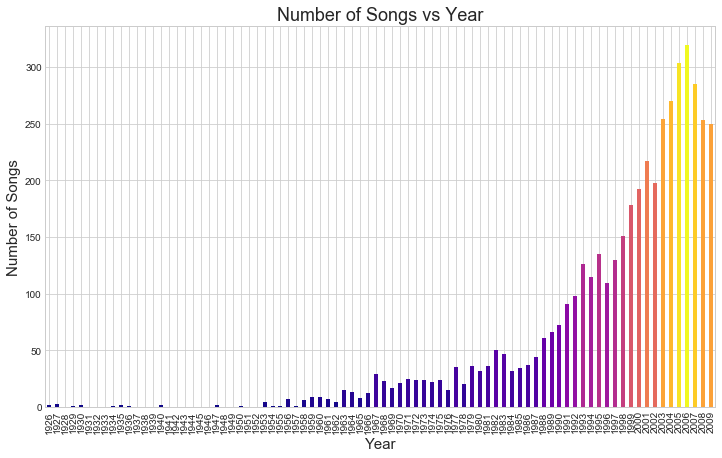

In [9]:
# Visualizing the number of songs per year
l_col = songs_per_yr / songs_per_yr.max()
songs_per_yr.plot.bar(color=cm.plasma(l_col), figsize=(12,7))

plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.title('Number of Songs vs Year');

Looking at the very unbalanced distribution of songs per year it appears that the initial statistical indicators are not carrying very meaningful information.
We can clearly see that the dataset is biased toward more recent songs.

### Songs and Albums Authors

Now we know there is a year bias, let's look at the songs author. Is there another bias ?

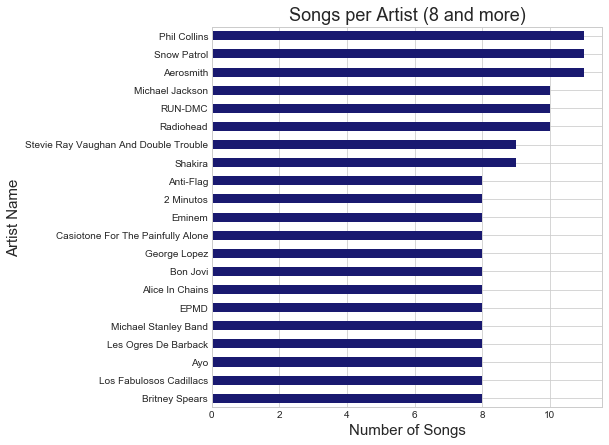

In [10]:
# Counting the number of entry per artist
songs_per_artist = songs.artist_name.value_counts()
songs_per_artist[songs_per_artist >= 8].sort_values().plot.barh(color='midnightblue', figsize=(7,7))
plt.title('Songs per Artist (8 and more)')
plt.xlabel('Number of Songs')
plt.ylabel('Artist Name');

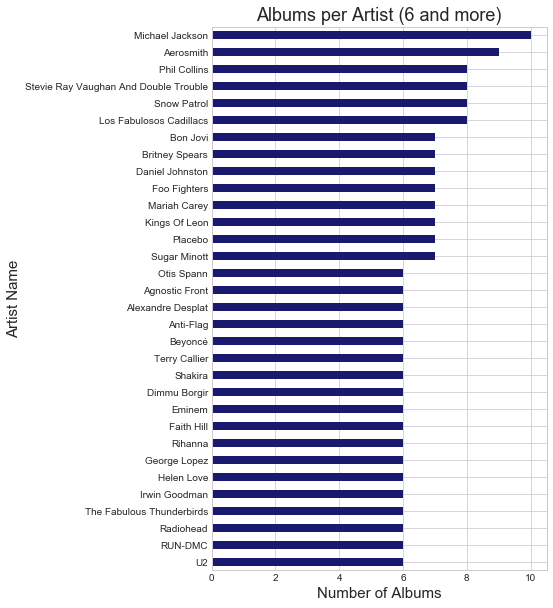

In [11]:
# Number of different albums release per artist
songs_per_art_and_rel = songs.groupby(['artist_name']).release.nunique()
songs_per_art_and_rel[songs_per_art_and_rel >= 6].sort_values().plot.barh(color='midnightblue', figsize=(6,10))
plt.title('Albums per Artist (6 and more)')
plt.xlabel('Number of Albums')
plt.ylabel('Artist Name');

The dataset is made of 4680 songs while there is a maximum of 11 songs and 10 unique albums per artist... we can reasonably conclude that there is no bias toward a specific artist or album. 

### Songs Duration

Contrary to the very unbalanced historical distribution of songs we would expect the songs duration to follow more closely a Normal distribution.

Before looking at the histogram we display a couple of statistical quantities (especially to check the minimum and maximum) :

In [12]:
songs.duration.describe()

count    4680.000000
mean      238.781146
std       101.345438
min         1.044440
25%       181.152200
50%       227.382400
75%       278.406080
max      1598.197100
Name: duration, dtype: float64

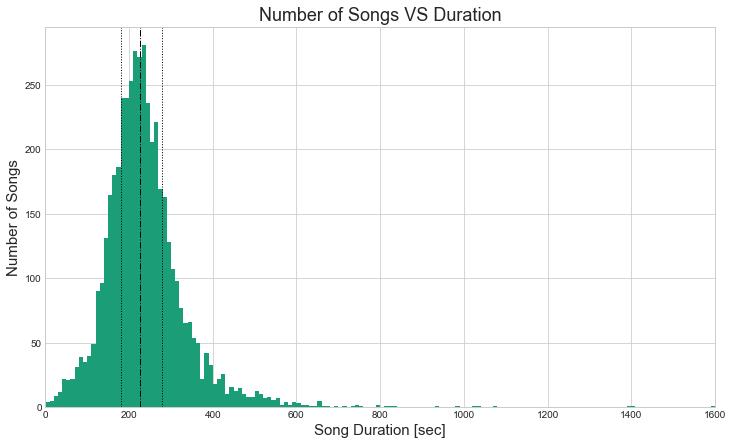

In [13]:
# Looking at the songs distribution in bins of 10seconds
songs.duration.plot.hist(bins=np.arange(0.0, 1610.0, 10.0), figsize=(12,7))
# Visualizing the quartiles
plt.axvline(181.1522, linestyle=':', lw=1.0, c='k')
plt.axvline(227.3824, linestyle='-.', lw=1.0, c='k')
plt.axvline(278.40608, linestyle=':', lw=1.0, c='k')

plt.xlim(0.0,1600)
plt.xlabel('Song Duration [sec]')
plt.ylabel('Number of Songs')
plt.title('Number of Songs VS Duration');

Despite a couple of pretty long songs (nearly 27minutes for the maximum) the distribution appears roughly symmetrical. This is partially confirmed by the small difference between the mean and the median.

Confirmation of the degree of symmetry can be found in the skewness of the distribution :

In [14]:
# computing  distribution skewness
print('Skewness : {:.3f}'.format(skew(songs.duration.values)))

Skewness : 2.566


The fact that the skewness is positive but not very large indicates that the distribution is slightly assymetric, with a tail longer for values higher than the median (as we can see).

Often the kurtosis is computed as well to give an idea of how "flat/pointy" is the distribution. In our case we expect a positive value (rather pointy) :

In [15]:
# computing the kurtosis 
print('Kurtosis : {:.3f}'.format(kurtosis(songs.duration.values)))

Kurtosis : 19.889


### Songs Hotness and Familiarity

In this section we focus on two engineered featured, namely the artist _hotness_ and _familiarity_

In [16]:
songs[['artist_hotttnesss','artist_familiarity']].describe()

,artist_hotttnesss,artist_familiarity
count,4680.000000,4680.000000
mean,0.441711,0.631585
std,0.128043,0.140808
min,0.000000,0.000000
25%,0.366820,0.540750
50%,0.420938,0.622875
75%,0.511054,0.727230
max,1.082503,1.000000


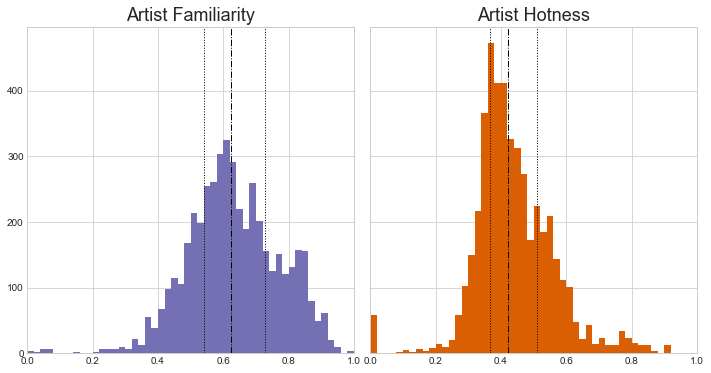

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharex=True, sharey=True)

songs.artist_familiarity.hist(bins=np.arange(0.0,1.02,0.02), ax=ax[0], color='C2');
ax[0].set_title('Artist Familiarity')
ax[0].axvline(0.54075, linestyle=':', lw=1.0, c='k')
ax[0].axvline(0.622875, linestyle='-.', lw=1.0, c='k')
ax[0].axvline(0.72723, linestyle=':', lw=1.0, c='k')

songs.artist_hotttnesss.hist(bins=np.arange(0.0,1.02,0.02), ax=ax[1], color='C1');
ax[1].set_title('Artist Hotness')
ax[1].axvline(0.36682, linestyle=':', lw=1.0, c='k')
ax[1].axvline(0.420938, linestyle='-.', lw=1.0, c='k')
ax[1].axvline(0.511054, linestyle=':', lw=1.0, c='k')

ax[-1].set_xlim(0.0,1.0)
plt.subplots_adjust(wspace=0.05);

This is not much information to extract from the one-dimensional anlaysis of these two features, later we will come back to the relationship between hotness and familiarity that shows much more interesting patterns.

## Looking at Patterns and Correlations

One dimensional analysis is by definition limited and in this section we will investigate further correlations between features and possible existing patterns.

An easy way to visualize possible patterns is to use a pair grid where every feature is plotted against the others :

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)


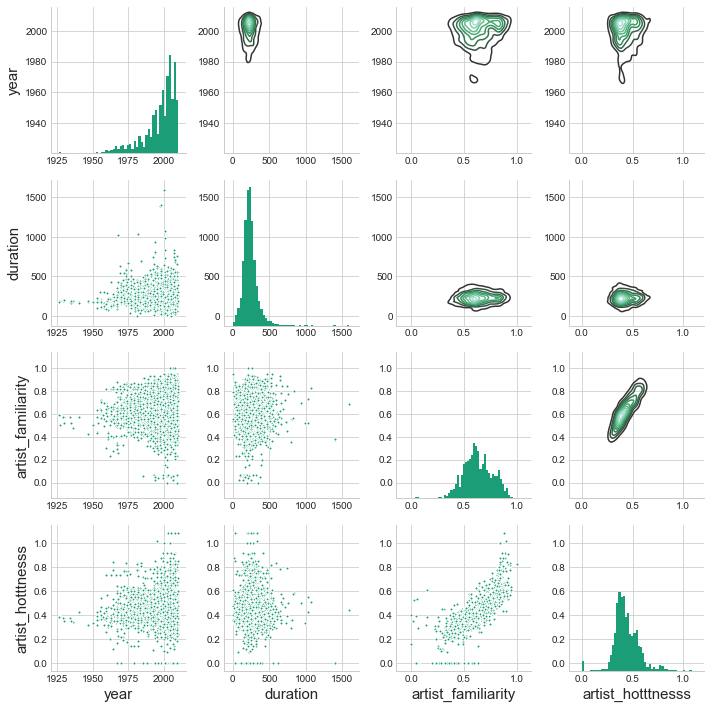

In [20]:
g = sb.PairGrid(songs, vars=['year','duration','artist_familiarity','artist_hotttnesss'])
g.map_upper(sb.kdeplot)
g.map_lower(plt.scatter, marker='.', edgecolor='w')
g.map_diag(plt.hist, bins=51);

Wa can clearly see that there is a correlation between artist familiarity and hotness. In order to quantify such correlation we compute the (Pearson) correlation coefficient between all pairs :

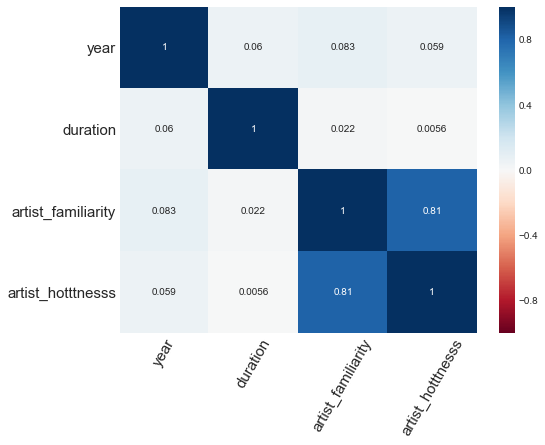

In [21]:
features = ['year','duration','artist_familiarity','artist_hotttnesss']
corr_mat = np.corrcoef(songs[features].values.T)
ax = sb.heatmap(corr_mat, xticklabels=features, yticklabels=features,
                cmap='RdBu', vmin=-1.0, vmax=1.0, annot=True)
plt.setp( ax.xaxis.get_majorticklabels(), fontsize=15, rotation=60 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=15, rotation=0 );

Well, artist familiarity and hotness are highly correlated with a coefficient of ~0.81 while other features are much more independent from each other (coefficient < 0.1).

In the following we will take a closer look at the pair familiarity-hotness and try to better understand the correlation between these two features.

## Artist Hotness vs Artist Familiarity

Let's first have a look again at the dataset in this 2-D space defined by the artist hotness and familiarity :

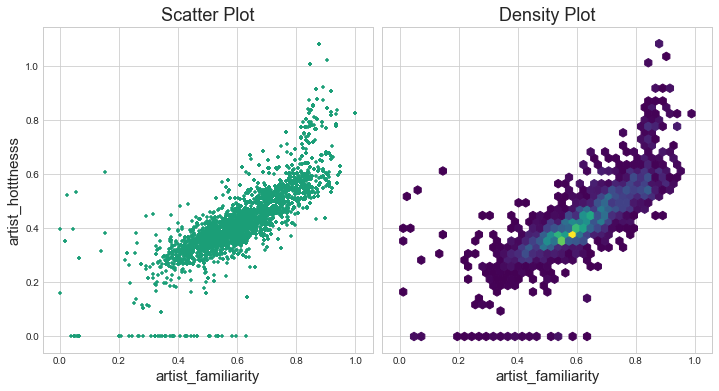

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(12,6))

songs.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', marker='+', ax=ax[0])
songs.plot.hexbin(x='artist_familiarity', y='artist_hotttnesss', ax=ax[1],
                  gridsize=41, mincnt=1.0, cmap='viridis', colorbar=False)

ax[0].set_title('Scatter Plot')
ax[1].set_title('Density Plot')
plt.subplots_adjust(wspace=0.03);

### Familiarity vs Hotness Clustering

When looking at the previous figures one can easily spot a "main sequence" (term borrowed from astronomy) where hotness linearly increase with familiarity and a number of cases where hotness is nearly zero if not zero. In addition there seems to be a different relationship between hotness and familiarity at high familiarity (>0.8) and numerous outliers surrounding the "main sequence" and at low familiarity (<0.4).

To better understand the pattern(s) in this 2-D space we choose to use an unsupervised clustering approach with the hope that it will reveal interesting structure.  
We decided to illustrate this approach with two methods :
* The Gaussian Mixture Model (GMM) which makes the assumptions that the distribution can be viewed as samples from _k_ Gaussian distributions.
* Agglomerative Clustering, a hierarchical clustering approach, grouping samples by increasing distance.

Both methods require the user to define _a priori_ the number of clusters which can then be validated using measures such as the _$\log[Likelihood]$_, _Bayesian Information Criteria_ (BIC) or the _Akaike Information Criteria_ (AIC).

Hereafter we exclude the collection of points with hotness at zero as it may very well prevents clustering from giving sensible results.

In [24]:
# checking the number of points at hotness = 0
songs[songs.artist_hotttnesss == 0.0].song_id.nunique()

58

In [25]:
# importing the methods
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [26]:
# Selecting only the useful part of the dataset
songs_cl = songs[songs.artist_hotttnesss != 0.0][['artist_familiarity','artist_hotttnesss']]

In order to estimate the optimal number of clusters we iteratively compute the different metrics with GMM :

In [29]:
# Here we compute metrics for GMM with different number of clusters
scores_n = []

for i in range(2,12):
    print('number of clusters : {}'.format(i))
    gmm = GaussianMixture(n_components=i, covariance_type='full')
    bic, aic, log = 0.0, 0.0, 0.0
    for j in range(7):
        gmm.fit(songs_cl)
        bic += gmm.bic(songs_cl)
        aic += gmm.aic(songs_cl)
        log += gmm.score(songs_cl)
    scores_n.append([np.mean(bic), np.mean(aic), np.mean(log)])
    
scores_n = np.asarray(scores_n)

number of clusters : 2
number of clusters : 3
number of clusters : 4
number of clusters : 5
number of clusters : 6
number of clusters : 7
number of clusters : 8
number of clusters : 9
number of clusters : 10
number of clusters : 11


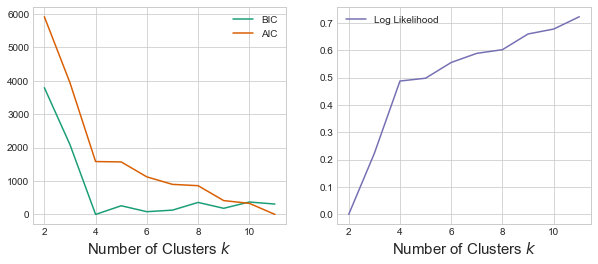

In [30]:
# Visualizing the results
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,4))

ax[0].plot(range(2,12), scores_n[:,0] - np.min(scores_n[:,0]), 'C0')
ax[0].plot(range(2,12), scores_n[:,1] - np.min(scores_n[:,1]), 'C1')
ax[0].legend(['BIC','AIC'])
ax[0].set_xlabel('Number of Clusters $k$')

ax[1].plot(range(2,12), scores_n[:,2] - np.min(scores_n[:,2]), 'C2')
ax[1].legend(['Log Likelihood'])
ax[1].set_xlabel('Number of Clusters $k$');

When looking at the _AIC_ and _BIC_ the optimal number of clusters is given by the minimum while with the $\log[Likelihood]$ we look at the change in the slope ("elbow").
It is always more sensible to look at different metrics when it comes to clustering.  
With this in mind, metrics seem to indicate that $k=4$ gives the best result for our dataset.

Let's look at the resulting clustering :

In [31]:
# Defining GMM with k=4 clusters
gmm_4 = GaussianMixture(n_components=4, covariance_type='full')
gmm_4.fit(songs_cl)
gmm_4_pred = gmm_4.predict_proba(songs_cl)

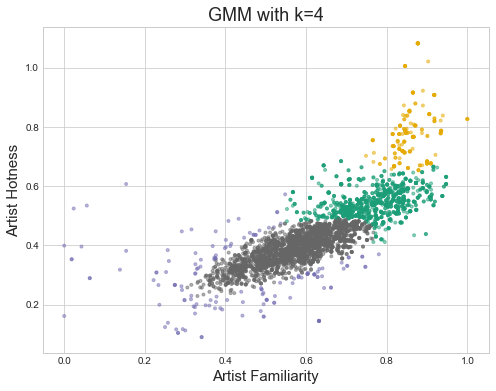

In [44]:
# Visualizing the result
plt.scatter(songs_cl.artist_familiarity, songs_cl.artist_hotttnesss, c=np.argmax(gmm_4_pred, axis=1),
            marker='.', alpha=0.5, cmap='Dark2_r')
plt.title('GMM with k=4')
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotness');

Well... even if metrics recommend four clusters, resulting groups differ significantly from the intuition we have. Let's try with maybe $k=3$ :

In [33]:
# Defining GMM with k=3 clusters
gmm_3 = GaussianMixture(n_components=3, covariance_type='full')
gmm_3.fit(songs_cl)
gmm_3_pred = gmm_3.predict_proba(songs_cl)

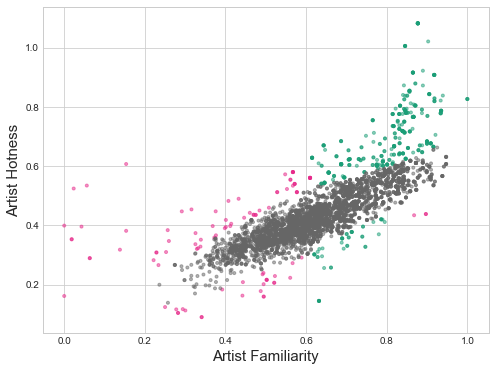

In [34]:
# Visualizing the result
plt.scatter(songs_cl.artist_familiarity, songs_cl.artist_hotttnesss, c=np.argmax(gmm_3_pred, axis=1),
            marker='.', alpha=0.5, cmap='Dark2_r')
plt.title('GMM with k=3')
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotness');

That is much closer to the intuition we had.
Let's have a look at what Agglomerative clustering suggests (with 4 and 3 clusters) :

In [35]:
# Agglomerative Clustering with k=4 clusters
agg_4 = AgglomerativeClustering(n_clusters=4, linkage='average')
agg_4_pred = agg_4.fit_predict(songs_cl)

In [45]:
# Agglomerative Clustering with k=3 clusters
agg_3 = AgglomerativeClustering(n_clusters=3, linkage='average')
agg_3_pred = agg_3.fit_predict(songs_cl)

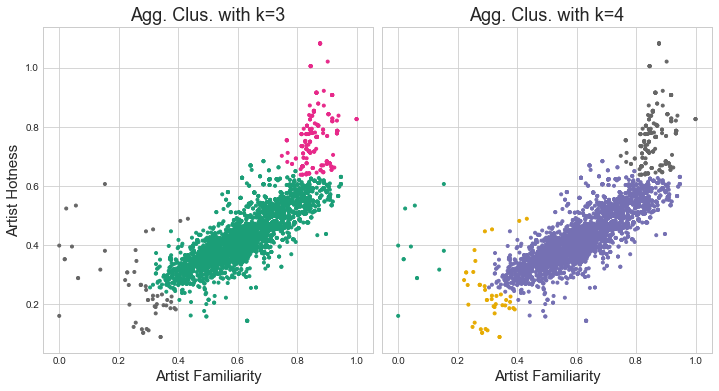

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,6))

ax[0].scatter(songs_cl.artist_familiarity, songs_cl.artist_hotttnesss, c=agg_3_pred,
              marker='.', alpha=1.0, cmap='Dark2_r')
ax[0].set_title('Agg. Clus. with k=3')
ax[0].set_xlabel('Artist Familiarity')
ax[0].set_ylabel('Artist Hotness')

ax[1].scatter(songs_cl.artist_familiarity, songs_cl.artist_hotttnesss, c=agg_4_pred,
              marker='.', alpha=1.0, cmap='Dark2_r')
ax[1].set_title('Agg. Clus. with k=4')
ax[1].set_xlabel('Artist Familiarity')

plt.subplots_adjust(wspace=0.025);

It is possible to look separately at the resulting clusters from both methods.

In [47]:
songs_cl['gmm'] = np.argmax(gmm_3_pred, axis=1)
songs_cl['agg_clus'] = agg_3_pred

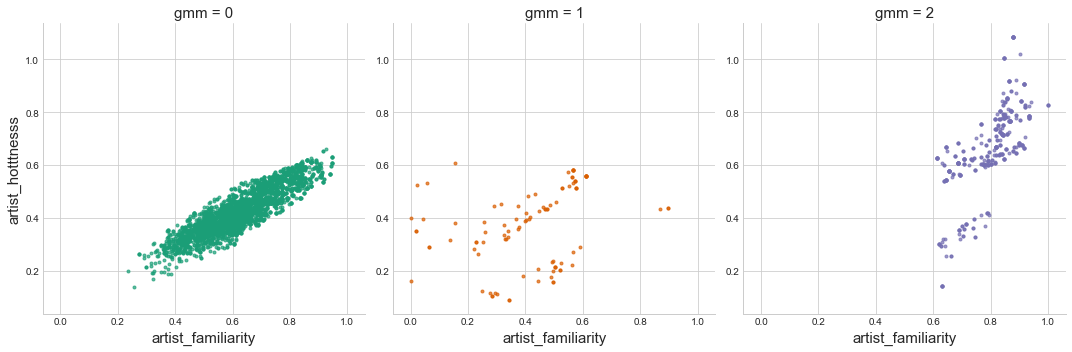

In [48]:
sb.lmplot(data=songs_cl, x='artist_familiarity', y='artist_hotttnesss',
          hue='gmm', col='gmm',
          fit_reg=False, markers='.', scatter_kws={'alpha':0.7});

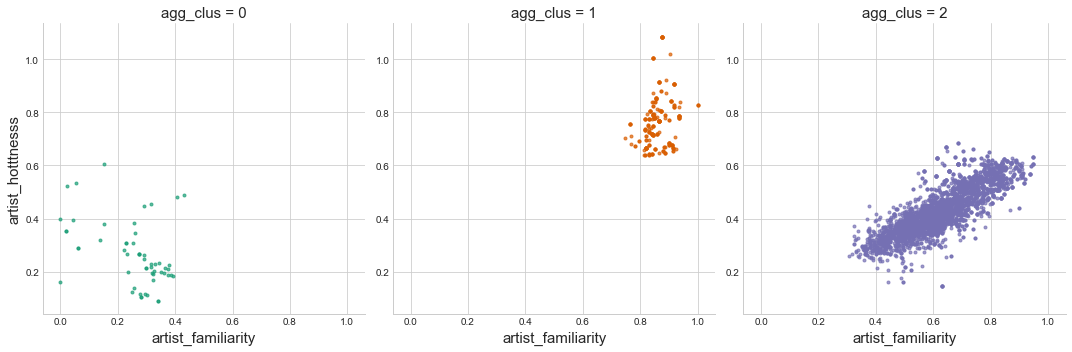

In [49]:
sb.lmplot(data=songs_cl, x='artist_familiarity', y='artist_hotttnesss',
          hue='agg_clus', col='agg_clus',
          fit_reg=False, markers='.', scatter_kws={'alpha':0.7});

The nature of the GMM method result in our case in two clusters presenting a gap while both methods recover a pretty similar "main sequence". Therefore we will keep Agglomerative Clustering results.

Clustering quality assessment can be very tedious and there exists a lot of metrics for this purpose. However, we choose to limit ourselves to the previous qualitative analysis.

## Linear Regression of the Clustering

Now we have defined three different groups it is interesting to introduce some quantification.

First we perform a linear regression of the "main sequence" as it exhibits a clear correlation.

In [53]:
songs_linreg = np.polyfit(songs_cl.artist_familiarity[songs_cl.agg_clus == 2].values,
                          songs_cl.artist_hotttnesss[songs_cl.agg_clus == 2].values, 1)
print("Linear Regression of the 'main sequence' :\n\
Hotness = {:.4f} * Familiarity + {:.4f}".format(songs_linreg[0],songs_linreg[1]))

Linear Regression of the 'main sequence' :
Hotness = 0.5944 * Familiarity + 0.0582


We can actually look at what a linear regression would have given on the GMM result :

In [54]:
songs_linreg_gmm = np.polyfit(songs_cl.artist_familiarity[songs_cl.gmm == 0].values,
                              songs_cl.artist_hotttnesss[songs_cl.gmm == 0].values, 1)
print("Linear Regression of the 'main sequence' :\n\
Hotness = {:.4f} * Familiarity + {:.4f}".format(songs_linreg_gmm[0],songs_linreg_gmm[1]))

Linear Regression of the 'main sequence' :
Hotness = 0.5920 * Familiarity + 0.0563


As expected (and fortunately) results are very similar.
Let's visualize the result :

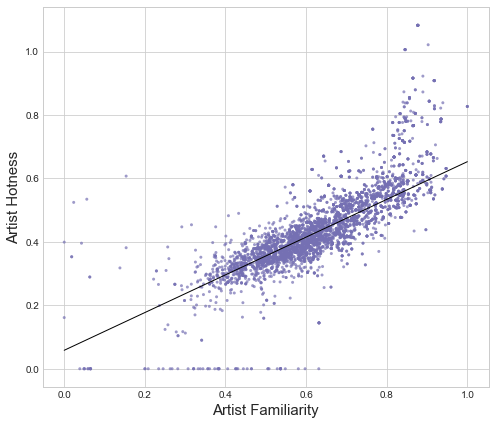

In [63]:
plt.figure(figsize=(8,7))
plt.scatter(songs.artist_familiarity, songs.artist_hotttnesss,
            marker='.', edgecolors='none', c='C2', alpha=0.7)
plt.plot([0.0,1.0], [0.0,songs_linreg[0]] + songs_linreg[1], 'k', lw=1.0)
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotness');

This line can be viewed as a reference of expected hotness given the artist familiarity.

Somehow points below the line can be viewed as artist songs being less hot than expected while points above this line are artists that have exceeded expectations!